In [1]:
from models.CA import CAA2

In [2]:
import torch

import pandas as pd
import numpy as np
from tqdm import tqdm
from utils import charas
import matplotlib.pyplot as plt
import gc
import os

from models.CA import CA0, CA1, CA2, CA3

import warnings
warnings.filterwarnings('ignore')

def model_inference_and_predict_CA(model):
    mon_list = pd.read_pickle('data/mon_list.pkl')
    test_mons = mon_list.loc[mon_list >= model.test_period[0]]
    inference_result = pd.DataFrame()
    predict_result = pd.DataFrame()
    T_bar = tqdm(test_mons.groupby(test_mons.apply(lambda x: x//10000)), colour='red', desc=f'{model.name} Inferencing & Predicting')
    
    stock_index = pd.Series(dtype=np.int64)
    for g in T_bar: # rolling train
        T_bar.set_postfix({'Year': g[0]})

        model.reset_weight()
        model.release_gpu()
         # release GPU memory
        torch.cuda.empty_cache()
        torch.cuda.empty_cache()
        torch.cuda.empty_cache()
        torch.cuda.empty_cache()
        torch.cuda.empty_cache()
        torch.cuda.empty_cache()

        train_loss, val_loss = model.train_model()
        # plot loss
        plt.plot(train_loss, label='train_loss')
        plt.plot(val_loss, label='val_loss')
        plt.legend()
        plt.savefig(f'results/train_loss/{model.name}_loss_{g[0]}.png')
        plt.close()

        
        for m in g[1].to_list():
            m_stock_index, _, _, _ = model._get_item(m)
            stock_index = pd.concat([stock_index, pd.Series(m_stock_index)]).drop_duplicates().astype(int)
            inference_R = model.inference(m) # return (N, 1)
            predict_R = model.predict(m) # reutrn (N, 1)

            # move inference_R and predict_R to cpu
            inference_R = inference_R.cpu().detach().numpy()
            predict_R = predict_R.cpu().detach().numpy()

            inference_R = pd.DataFrame(inference_R, index=m_stock_index, columns=[m])
            predict_R = pd.DataFrame(predict_R, index=m_stock_index, columns=[m])

            
            inference_result = pd.concat([inference_result.reset_index(drop=True), inference_R.reset_index(drop=True)], axis=1) # (N, T)
            predict_result = pd.concat([predict_result.reset_index(drop=True), predict_R.reset_index(drop=True)], axis=1) # (N, T)

            # DEBUG:
            # save inference_R and predict_R to csv
            # inference_result.to_csv(f'temp/{model.name}_inference_stock_{m}.csv')
            # predict_result.to_csv(f'temp/{model.name}_predict_stock_{m}.csv')
            
        # model refit (change train period and valid period)
        model.refit()

    inference_result = pd.DataFrame(inference_result.values.T, index=test_mons, columns=charas)
    inference_result.to_csv(f'results/inference/{model.name}_inference.csv')
    
    predict_result = pd.DataFrame(predict_result.values.T, index=test_mons, columns=charas)
    predict_result.to_csv(f'results/predict/{model.name}_predict.csv')

    # GC: release RAM memory(model)
    del model
    gc.collect()
    return inference_result, predict_result

OOS_start = 19870101
OOS_end = 20161231

def calculate_R2(model, type, portfolio = True):
    if portfolio:
        portfolio_ret = pd.read_pickle('data/portfolio_ret.pkl')
    else:
        raise Exception('Unrealized Function')
    oos_ret = portfolio_ret.loc[(portfolio_ret['DATE'] >= OOS_start) & (portfolio_ret['DATE'] <= OOS_end)]
    
    output_path = f'results/{type}/{model}_{type}.csv'
    model_output = pd.read_csv(output_path)
    
    residual_square = (oos_ret.set_index('DATE') - model_output.set_index('DATE'))**2
    residual_square = (1 - (residual_square == np.inf) * 1.0) * residual_square # drop Inf outliers
    
    total_square = oos_ret.set_index('DATE')**2
    total_square = (1 - (total_square == np.inf) * 1.0) * total_square # drop Inf outliers
    
    return 1 - np.sum(residual_square.values)/np.sum(total_square.values)

def alpha_plot(model, type, portfolio = True):
    if not portfolio:
        raise Exception('Unrealized Function')
    
    portfolio_ret = pd.read_pickle('data/portfolio_ret.pkl')
    oos_result = portfolio_ret.loc[(portfolio_ret['DATE'] >= OOS_start) & (portfolio_ret['DATE'] <= OOS_end)].set_index('DATE')
    
    output_path = f'results/{type}/{model}_{type}.csv'
    inference_result = pd.read_csv(output_path)
    inference_result = inference_result.set_index('DATE')
    
    
    pricing_error_analysis = []
    for col in charas:
        raw_return = oos_result[col].mean()
        error = oos_result[col] - inference_result[col]
        alpha = error.mean()
        t_stat = abs(error.mean()/error.std()) * np.sqrt(oos_result.shape[0])
        pricing_error_analysis.append([raw_return, alpha, t_stat])

    pricing_error_analysis = pd.DataFrame(pricing_error_analysis, columns = ['raw ret', 'alpha', 't_stat'], index=charas)
    
    lower_point = min(np.min(pricing_error_analysis['raw ret']), np.min(pricing_error_analysis['alpha'])) * 1.15
    upper_point = max(np.max(pricing_error_analysis['raw ret']), np.max(pricing_error_analysis['alpha'])) * 1.15

    significant_mask = pricing_error_analysis['t_stat'] > 3

    plt.scatter(pricing_error_analysis.loc[significant_mask]['raw ret'], pricing_error_analysis.loc[significant_mask]['alpha'], marker='^', color='r', alpha=0.6, label=f'#Alphas(t>3.0)={np.sum(significant_mask*1.0)}')
    plt.scatter(pricing_error_analysis.loc[~significant_mask]['raw ret'], pricing_error_analysis.loc[~significant_mask]['alpha'], marker='o', color='b', alpha=0.6, label=f'#Alphas(t<3.0)={94-np.sum(significant_mask*1.0)}')
    plt.plot(np.linspace(lower_point, upper_point, 10), np.linspace(lower_point, upper_point, 10), color='black')

    plt.ylabel('Alpha')
    plt.xlabel('Raw Return')
    plt.legend()

    plt.title(model)
    plt.savefig(f'results/{type}/{model}_{type}_alpha_plot.png')
    plt.close()

In [4]:
model = CAA2(6).to('cuda')
t, v = model_inference_and_predict_CA(model)

CAA2_6 Inferencing & Predicting:   0%|          | 0/30 [00:00<?, ?it/s, Year=1987]

Early stop at epoch 38


CAA2_6 Inferencing & Predicting:   3%|▎         | 1/30 [00:45<22:08, 45.80s/it, Year=1988]

Early stop at epoch 172


CAA2_6 Inferencing & Predicting:   7%|▋         | 2/30 [04:07<1:04:04, 137.31s/it, Year=1989]

Early stop at epoch 77


CAA2_6 Inferencing & Predicting:  10%|█         | 3/30 [05:47<54:16, 120.62s/it, Year=1990]  

Early stop at epoch 65


CAA2_6 Inferencing & Predicting:  13%|█▎        | 4/30 [07:18<47:04, 108.63s/it, Year=1991]

Early stop at epoch 72


CAA2_6 Inferencing & Predicting:  17%|█▋        | 5/30 [09:02<44:35, 107.02s/it, Year=1992]

Early stop at epoch 82


CAA2_6 Inferencing & Predicting:  20%|██        | 6/30 [11:04<44:53, 112.22s/it, Year=1993]

Early stop at epoch 36


CAA2_6 Inferencing & Predicting:  23%|██▎       | 7/30 [12:02<36:14, 94.52s/it, Year=1994] 

Early stop at epoch 47


CAA2_6 Inferencing & Predicting:  27%|██▋       | 8/30 [13:19<32:34, 88.83s/it, Year=1995]

Early stop at epoch 31


CAA2_6 Inferencing & Predicting:  30%|███       | 9/30 [14:13<27:20, 78.10s/it, Year=1996]

Early stop at epoch 36


CAA2_6 Inferencing & Predicting:  33%|███▎      | 10/30 [15:18<24:36, 73.81s/it, Year=1997]

Early stop at epoch 76


CAA2_6 Inferencing & Predicting:  37%|███▋      | 11/30 [17:32<29:13, 92.27s/it, Year=1998]

Early stop at epoch 41


CAA2_6 Inferencing & Predicting:  40%|████      | 12/30 [18:49<26:21, 87.85s/it, Year=1999]

Early stop at epoch 59


CAA2_6 Inferencing & Predicting:  43%|████▎     | 13/30 [20:43<27:04, 95.55s/it, Year=2000]

Early stop at epoch 32


CAA2_6 Inferencing & Predicting:  47%|████▋     | 14/30 [21:49<23:05, 86.58s/it, Year=2001]

Early stop at epoch 57


CAA2_6 Inferencing & Predicting:  50%|█████     | 15/30 [23:44<23:51, 95.41s/it, Year=2002]

Early stop at epoch 49


CAA2_6 Inferencing & Predicting:  53%|█████▎    | 16/30 [25:29<22:52, 98.01s/it, Year=2003]

Early stop at epoch 31


CAA2_6 Inferencing & Predicting:  57%|█████▋    | 17/30 [26:39<19:26, 89.73s/it, Year=2004]

Early stop at epoch 37


CAA2_6 Inferencing & Predicting:  60%|██████    | 18/30 [28:03<17:34, 87.87s/it, Year=2005]

Early stop at epoch 58


CAA2_6 Inferencing & Predicting:  63%|██████▎   | 19/30 [30:15<18:32, 101.18s/it, Year=2006]

Early stop at epoch 51


CAA2_6 Inferencing & Predicting:  67%|██████▋   | 20/30 [32:13<17:42, 106.28s/it, Year=2007]

Early stop at epoch 31


CAA2_6 Inferencing & Predicting:  70%|███████   | 21/30 [33:29<14:35, 97.28s/it, Year=2008] 

Early stop at epoch 30


CAA2_6 Inferencing & Predicting:  73%|███████▎  | 22/30 [34:47<12:12, 91.58s/it, Year=2009]

Early stop at epoch 44


CAA2_6 Inferencing & Predicting:  77%|███████▋  | 23/30 [36:43<11:32, 98.88s/it, Year=2010]

Early stop at epoch 46


CAA2_6 Inferencing & Predicting:  80%|████████  | 24/30 [38:48<10:39, 106.59s/it, Year=2011]

Early stop at epoch 48


CAA2_6 Inferencing & Predicting:  83%|████████▎ | 25/30 [41:00<09:31, 114.24s/it, Year=2012]

Early stop at epoch 21


CAA2_6 Inferencing & Predicting:  87%|████████▋ | 26/30 [42:04<06:36, 99.03s/it, Year=2013] 

Early stop at epoch 24


CAA2_6 Inferencing & Predicting:  90%|█████████ | 27/30 [43:16<04:33, 91.18s/it, Year=2014]

Early stop at epoch 32


CAA2_6 Inferencing & Predicting:  93%|█████████▎| 28/30 [44:53<03:05, 92.91s/it, Year=2015]

Early stop at epoch 49


CAA2_6 Inferencing & Predicting:  97%|█████████▋| 29/30 [47:20<01:49, 109.11s/it, Year=2016]

Early stop at epoch 87


CAA2_6 Inferencing & Predicting: 100%|██████████| 30/30 [51:41<00:00, 103.37s/it, Year=2016]


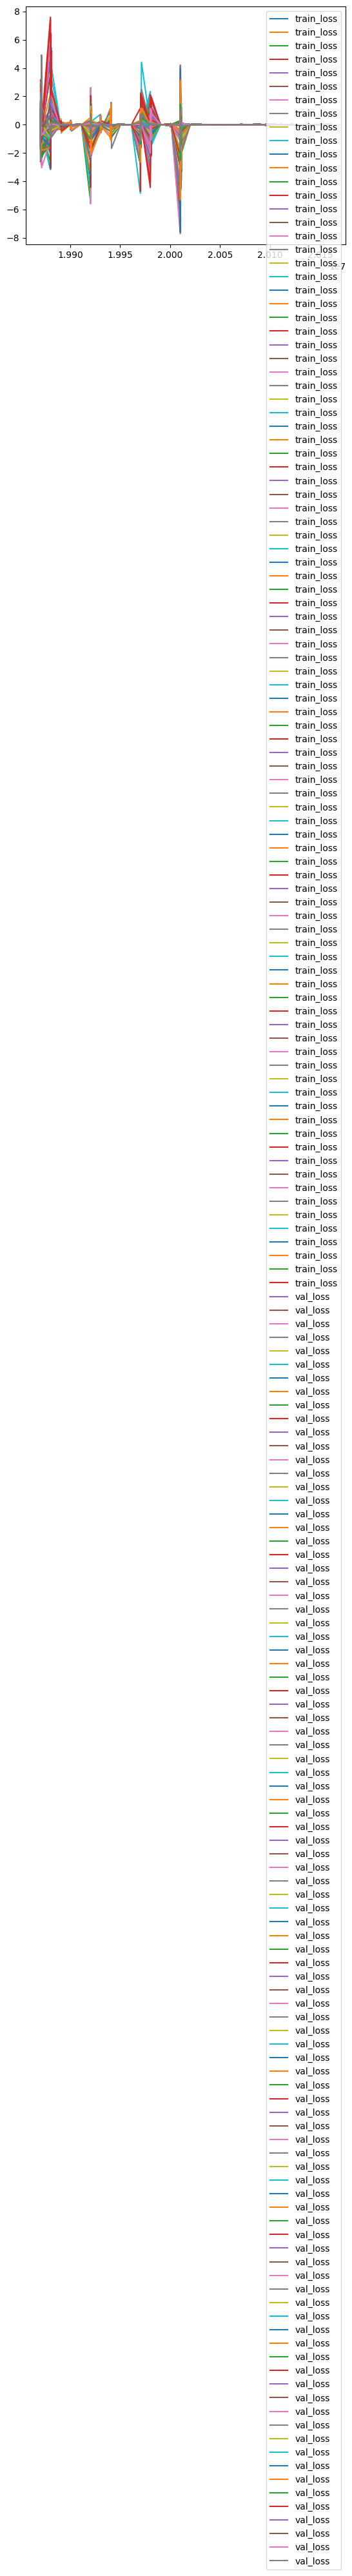

In [5]:
from matplotlib import pyplot as plt
plt.plot(t, label='train_loss')
plt.plot(v, label='val_loss')
plt.legend()
plt.show()

In [6]:
calculate_R2('CAA2_6', 'inference')

0.03317699128031548

In [ ]:
alpha_plot('CAA2_6', 'inference')